# 1. Import Depedencies

In [1]:
# Install Depedencies
!pip -q install keras_applications
!pip -q install git+https://github.com/rcmalli/keras-vggface.git@refs/pull/85/merge
!pip -q install hpelm

# Import Depedencies
import os
import sys
import time
import warnings
import numpy as np
import tensorflow as tf
import seaborn as sns
import random
import pandas as pd
from hpelm import ELM
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from keras_vggface.vggface import VGGFace
from tensorflow.keras.utils import Progbar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
warnings.filterwarnings("ignore")

# 2. Data Preparation

In [2]:
# create dataframe from file path
dataset_path = "../input/utkface-new/UTKFace" 
images = np.array([])
ages = np.array([])

for filename in os.listdir(dataset_path):
    ages = np.append(ages, filename.split('_')[0])
    images = np.append(images, f"../input/utkface-new/UTKFace/{filename}")
    
images = pd.Series(images, name = "Name")
ages = pd.Series(ages, name ="Age", dtype = 'int')
df = pd.concat([images,ages], axis = 1)
df.head()

,Name,Age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17


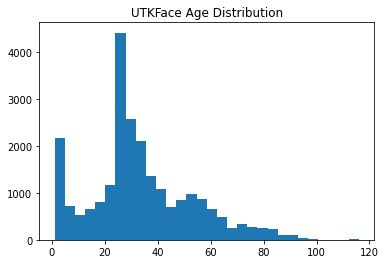

In [3]:
# Visualize Ages Distribution
df.hist(column = "Age",grid = False, bins = 30)
plt.title("UTKFace Age Distribution")
plt.show()

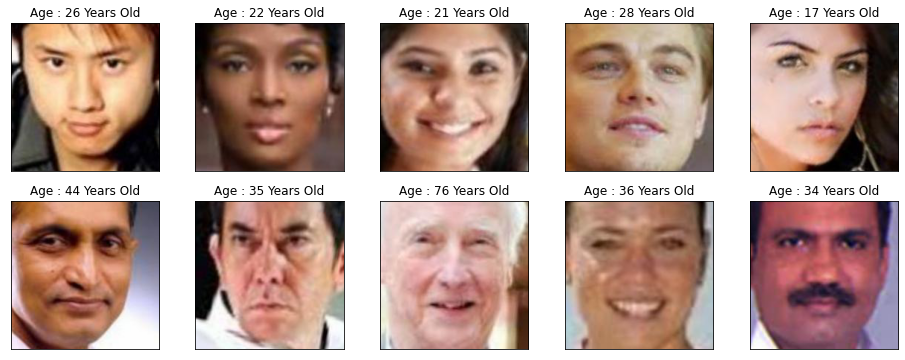

In [4]:
# Plot some sample images
plt.figure(figsize = (16,6))
for i in range(10):
    img = mpimg.imread(df.iloc[i]['Name'])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Age : {df.iloc[i]['Age']} Years Old")
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [5]:
# Classifying Age Into Several Groups (Adiance Dataset Group)
def ages_group(age):
    
    if(0 <= age <= 2):
        return "group 1"
    elif(4 <= age <= 6):
        return "group 2"
    elif(8 <= age <= 13):
        return "group 3"
    elif(15 <= age <= 20):
        return "group 4"
    elif(25 <= age <= 32):
        return "group 5"
    elif(38 <= age <= 43):
        return "group 6"
    elif(48 <= age <= 53):
        return "group 7"
    elif(age >= 60):
        return "group 8"
    else:
        return "no group"
    
ages_group = pd.Series(df['Age'].apply(ages_group), name = "Group")
df_group = pd.concat([df, ages_group], axis = 1)
df_group = df_group[df_group["Group"] != 'no group'].reset_index(drop = True)
df_group.head()

,Name,Age,Group
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,group 5
1,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,group 5
2,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,group 4
3,../input/utkface-new/UTKFace/76_0_0_2017010421...,76,group 8
4,../input/utkface-new/UTKFace/18_1_0_2017010402...,18,group 4


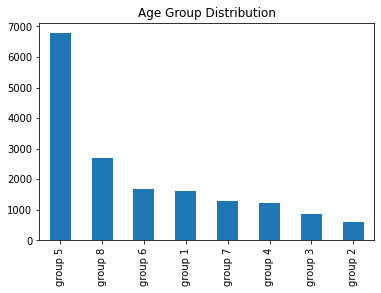

In [6]:
# Visualize Age Group Distribution
df_group["Group"].value_counts().plot.bar()
plt.title("Age Group Distribution")
plt.show()

In [7]:
# Split dataframe to train, validation and test
train_size = 0.80
validation_size = 0.10
test_size = 0.10

x = df_group["Name"]
y = df_group["Group"]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size + validation_size, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = validation_size/(train_size + validation_size), random_state = 42)

df_train = pd.concat({'Name':x_train,'Group':y_train}, axis = 1)
df_val = pd.concat({'Name':x_val,'Group':y_val}, axis = 1)
df_test = pd.concat({'Name':x_test,'Group':y_test}, axis = 1)

In [8]:
# Dataset pipeline
image_shape = (224, 224)
batch_size = 32

print("Training Data:")
train_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col = "Name", 
    y_col = "Group",
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"
)

print("\nValidation Data:")
val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_dataframe(
    dataframe = df_val,
    x_col = "Name",
    y_col = "Group",
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"
)

print("\nTest Data:")
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_dataframe(
    dataframe = df_test,
    x_col = "Name",
    y_col = "Group",
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"
)

Training Data:
Found 13375 validated image filenames belonging to 8 classes.

Validation Data:
Found 1672 validated image filenames belonging to 8 classes.

Test Data:
Found 1672 validated image filenames belonging to 8 classes.


# 3. CNN with ELM Class

In [9]:
# Disable and enable print function (used to blocks warning on HPELM Lib)
def blockPrint():
    sys.__stdout__ = sys.stdout
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

# Class of CNN with ELM
class CNN_ELM:
    def __init__(self, feature_extractor, elm_hidden_nodes, output_class, elm_act_func = "sigm"):
        
        # Create CNN as Feature Extractor
        if(feature_extractor == 'resnet50+imgnet'):            
            self.cnn = tf.keras.Sequential([
                ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3)),
                GlobalAveragePooling2D()
            ])
        elif(feature_extractor == 'vgg16+imgnet'):
            self.cnn = tf.keras.Sequential([
                VGG16(include_top = False, weights = 'imagenet', input_shape = (224,224,3)), 
                GlobalAveragePooling2D()
            ])
        elif(feature_extractor == 'resnet50+vggface'):
            self.cnn = tf.keras.Sequential([
                VGGFace(model = 'resnet50', weights = 'vggface', include_top = False, input_shape = (224,224,3)), 
                GlobalAveragePooling2D()
            ])
        elif(feature_extractor == 'vgg16+vggface'):
            self.cnn = tf.keras.Sequential([
                VGGFace(model = 'vgg16',weights = 'vggface', include_top = False, input_shape = (224,224,3)), 
                GlobalAveragePooling2D()
            ])
        else :
            raise Exception(f"Error : No CNN Architecure named {feature_extractor}")
        
        # Freeze CNN layers
        self.cnn.trainable = False
        
        # Set output size of cnn layers and elm layers
        self.cnn_output = self.cnn.layers[-1].output.shape[1]
        self.elm_output = output_class
        
        # Create ELM as Fully Connected Layer
        self.elm = ELM (inputs = self.cnn_output , outputs = self.elm_output)
        self.elm.add_neurons(elm_hidden_nodes, elm_act_func)
    
    def extract_feature(self, input):
        # extract feature map with cnn
        feature_map = self.cnn(input)      
        return feature_map

    def fit(self,dataset_train, total_size, verbose = 1):
        # Start Timer and progress bar
        pb = Progbar(len(dataset_train), stateful_metrics = ['acc'], verbose = verbose)
        start = time.time()
        
        # Extract Features per batch
        batches = 0
        features = np.array([]).reshape(0, self.cnn_output)
        labels = np.array([]).reshape(0, self.elm_output)
        for i, (x_batch, y_batch) in enumerate(dataset_train):
            # Get features maps and labels
            features = np.vstack([features, self.extract_feature(x_batch)]) 
            labels = np.vstack([labels, y_batch])
            
            # Progress bar update
            pb.update(i)
            
            # batch iterator
            batches += 1
            if batches >= total_size/ 32:
                break
                                
        # Train ELM
        blockPrint()
        self.elm.train(features, labels)
        enablePrint()
        
        # Stop Timer
        stop = time.time()
        total_time = stop - start
                
        # Calculate acc for data train
        preds = self.elm.predict(features)
        acc = accuracy_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1))
        
        # Progress bar update
        pb.update(len(dataset_train), values= [('acc', acc)], finalize=True)

        return acc, total_time
    
    def predict(self, input):
        # Extract Features
        features = np.array(self.extract_feature(input)) 
    
        # predict with ELM
        pred = self.elm.predict(features)
        
        return pred
        
    def evaluate(self, dataset_eval, total_size,  verbose = 1):
        # Start Timer and progress bar
        pb = Progbar(len(dataset_eval), stateful_metrics = ['acc'], verbose = verbose)
        start = time.time()
        
        # Predict images per batch
        batches = 0
        preds = np.array([]).reshape(0, self.elm_output)
        labels = np.array([]).reshape(0, self.elm_output)
        for i, (x_batch, y_batch) in enumerate(dataset_eval):
            # predict Images
            preds = np.vstack([preds, self.predict(x_batch)])
            labels = np.vstack([labels,y_batch])
            
            # Progress bar update
            pb.update(i)
          
            # Batch Iterator
            batches += 1
            if batches >= total_size / 32:
                break
              
        # Stop Timer
        stop = time.time()
        total_time = stop - start
     
        # Calculate acc, precision, recall, f1-score
        acc = accuracy_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1))
        prec = precision_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
        rec = recall_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
        f1 = f1_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
        
        # conf matrix
        cm = confusion_matrix(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1))
        
        # Progress bar update
        pb.update(len(dataset_eval), values = [('acc', acc)], finalize = True)
        
        return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'cm': cm}, total_time
    
    def save_model(self, path):
        self.cnn.save(path + "/" + "feature_extractor.h5")
        self.elm.save(path + "/" + "elm_classifier.pkl")

# 4. Experiments using CNN with ELM

In [10]:
# Performance Report
cnn_elm_eval = {
    'ResNet50+imgnet+ELM' : {},
    'Vgg16+imgnet+ELM' : {},
    'ResNet50+vggface+ELM' : {},
    'Vgg16+vggface+ELM' : {}   
}

## 4.1. ResNet50 (ImageNet Weights) with ELM

In [12]:
# Create ResNet50 with ELM oject
resnet50_imgnet_elm = CNN_ELM(feature_extractor = 'resnet50+imgnet', elm_hidden_nodes = 1024, output_class = 8)

# Fitting
print("Training ResNet50 (Imagenet Weights) with ELM")
_, train_time = resnet50_imgnet_elm.fit(dataset_train = train_data, total_size = len(x_train))

# Eval on Validation Data
print("\nEvaluating on Validation Data")
_, _ = resnet50_imgnet_elm.evaluate(dataset_eval = val_data, total_size = len(x_test))

# Eval on Test Data
print("\nEvaluating on Test Data")
test_report, test_time = resnet50_imgnet_elm.evaluate(dataset_eval = test_data, total_size = len(x_test))

# Add to Time Performance Report
cnn_elm_eval['ResNet50+imgnet+ELM']['Train Time'] = train_time
cnn_elm_eval['ResNet50+imgnet+ELM']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_elm_eval['ResNet50+imgnet+ELM']['Accuracy'] = test_report['acc']
cnn_elm_eval['ResNet50+imgnet+ELM']['Precision'] = test_report['prec']
cnn_elm_eval['ResNet50+imgnet+ELM']['Recall'] = test_report['rec']
cnn_elm_eval['ResNet50+imgnet+ELM']['F1-Score'] = test_report['f1']
cnn_elm_eval['ResNet50+imgnet+ELM']['Confusion Matrix'] = test_report['cm']

Training ResNet50 (Imagenet Weights) with ELM
418/418 [==============================] - 73s 175ms/step - acc: 0.6733

Evaluating on Validation Data
53/53 [==============================] - 9s 172ms/step - acc: 0.6184

Evaluating on Test Data
53/53 [==============================] - 9s 173ms/step - acc: 0.6154


## 4.2. VGG16 (ImageNet Weights) with ELM

In [13]:
# Create VGG16 with ELM oject
vgg16_imgnet_elm = CNN_ELM(feature_extractor = 'vgg16+imgnet', elm_hidden_nodes = 1024, output_class = 8)

# Fitting
print("Training VGG16 (Imagenet Weights) with ELM")
_, train_time = vgg16_imgnet_elm.fit(dataset_train = train_data, total_size = len(x_train))

# Eval on Validation Data
print("\nEvaluating on Validation Data")
_, _ = vgg16_imgnet_elm.evaluate(dataset_eval = val_data, total_size = len(x_val))

# Eval on Test Data
print("\nEvaluating on Test Data")
test_report, test_time = vgg16_imgnet_elm.evaluate(dataset_eval = test_data, total_size = len(x_test))

# Add to Time Performance Report
cnn_elm_eval['Vgg16+imgnet+ELM']['Train Time'] = train_time
cnn_elm_eval['Vgg16+imgnet+ELM']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_elm_eval['Vgg16+imgnet+ELM']['Accuracy'] = test_report['acc']
cnn_elm_eval['Vgg16+imgnet+ELM']['Precision'] = test_report['prec']
cnn_elm_eval['Vgg16+imgnet+ELM']['Recall'] = test_report['rec']
cnn_elm_eval['Vgg16+imgnet+ELM']['F1-Score'] = test_report['f1']
cnn_elm_eval['Vgg16+imgnet+ELM']['Confusion Matrix'] = test_report['cm']

58900480/58889256 [==============================] - 2s 0us/step
Training VGG16 (Imagenet Weights) with ELM
418/418 [==============================] - 70s 166ms/step - acc: 0.6873

Evaluating on Validation Data
53/53 [==============================] - 11s 198ms/step - acc: 0.6406

Evaluating on Test Data
53/53 [==============================] - 10s 184ms/step - acc: 0.6220


## 4.3. ResNet50 (VGGFace Weights) with ELM 

In [14]:
# Create ResNet50(vggface) with ELM
resnet50_vggface_elm = CNN_ELM(feature_extractor = 'resnet50+vggface', elm_hidden_nodes = 1024, output_class = 8)

# Fitting
print("Training ResNet50 (VggFace Weights) with ELM")
_, train_time = resnet50_vggface_elm.fit(dataset_train = train_data, total_size = len(x_train))

# Eval on Validation Data
print("\nEvaluating on Validation Data")
_, _ = resnet50_vggface_elm.evaluate(dataset_eval = val_data, total_size = len(x_val))

# Eval on Test Data
print("\nEvaluating on Test Data")
test_report, test_time = resnet50_vggface_elm.evaluate(dataset_eval = test_data, total_size = len(x_test))

# Add to Time Performance Report
cnn_elm_eval['ResNet50+vggface+ELM']['Train Time'] = train_time
cnn_elm_eval['ResNet50+vggface+ELM']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_elm_eval['ResNet50+vggface+ELM']['Accuracy'] = test_report['acc']
cnn_elm_eval['ResNet50+vggface+ELM']['Precision'] = test_report['prec']
cnn_elm_eval['ResNet50+vggface+ELM']['Recall'] = test_report['rec']
cnn_elm_eval['ResNet50+vggface+ELM']['F1-Score'] = test_report['f1']
cnn_elm_eval['ResNet50+vggface+ELM']['Confusion Matrix'] = test_report['cm']

94707712/94694792 [==============================] - 5s 0us/step
Training ResNet50 (VggFace Weights) with ELM
418/418 [==============================] - 69s 164ms/step - acc: 0.6679

Evaluating on Validation Data
53/53 [==============================] - 9s 173ms/step - acc: 0.6208

Evaluating on Test Data
53/53 [==============================] - 9s 170ms/step - acc: 0.6071


## 4.4. VGG16 (VGGFace Weights) with ELM 

In [15]:
# Create VGG16(vggface) with ELM
vgg16_vggface_elm = CNN_ELM(feature_extractor = 'vgg16+vggface', elm_hidden_nodes = 1024, output_class = 8)

# Fitting
print("Training VGG16 (VGGFace Weights) with ELM")
_, train_time = vgg16_vggface_elm.fit(dataset_train = train_data, total_size = len(x_train))

# Eval on Validation Data
print("\nEvaluating on Validation Data")
_, _ = vgg16_vggface_elm.evaluate(dataset_eval = val_data, total_size = len(x_val))

# Eval on Test Data
print("\nEvaluating on Test Data")
test_report, test_time = vgg16_vggface_elm.evaluate(dataset_eval = test_data, total_size = len(x_test))

# Add to Time Performance report
cnn_elm_eval['Vgg16+vggface+ELM']['Train Time'] = train_time
cnn_elm_eval['Vgg16+vggface+ELM']['Test Time'] = test_time

# Add to Classification performance report
cnn_elm_eval['Vgg16+vggface+ELM']['Accuracy'] = test_report['acc']
cnn_elm_eval['Vgg16+vggface+ELM']['Precision'] = test_report['prec']
cnn_elm_eval['Vgg16+vggface+ELM']['Recall'] = test_report['rec']
cnn_elm_eval['Vgg16+vggface+ELM']['F1-Score'] = test_report['f1']
cnn_elm_eval['Vgg16+vggface+ELM']['Confusion Matrix'] = test_report['cm']

58925056/58909280 [==============================] - 2s 0us/step
Training VGG16 (VGGFace Weights) with ELM
418/418 [==============================] - 69s 165ms/step - acc: 0.7560

Evaluating on Validation Data
53/53 [==============================] - 10s 188ms/step - acc: 0.6968

Evaluating on Test Data
53/53 [==============================] - 10s 182ms/step - acc: 0.7117


## 4.5. Evaluating Result

In [16]:
# summary by dataframe
df_eval_cnn_elm = pd.DataFrame.from_dict(cnn_elm_eval).transpose().reset_index().drop(columns = ['Confusion Matrix'])
df_eval_cnn_elm.rename(columns = {'index':'Model'}, inplace = True)
df_eval_cnn_elm

,Model,Train Time,Test Time,Accuracy,Precision,Recall,F1-Score
0,ResNet50+imgnet+ELM,71.559383,9.336356,0.615431,0.371375,0.478391,0.357715
1,Vgg16+imgnet+ELM,69.555467,9.914344,0.62201,0.403245,0.553518,0.403296
2,ResNet50+vggface+ELM,67.428524,9.134483,0.607057,0.373699,0.487207,0.363025
3,Vgg16+vggface+ELM,68.439223,9.851466,0.711722,0.512398,0.642823,0.522915


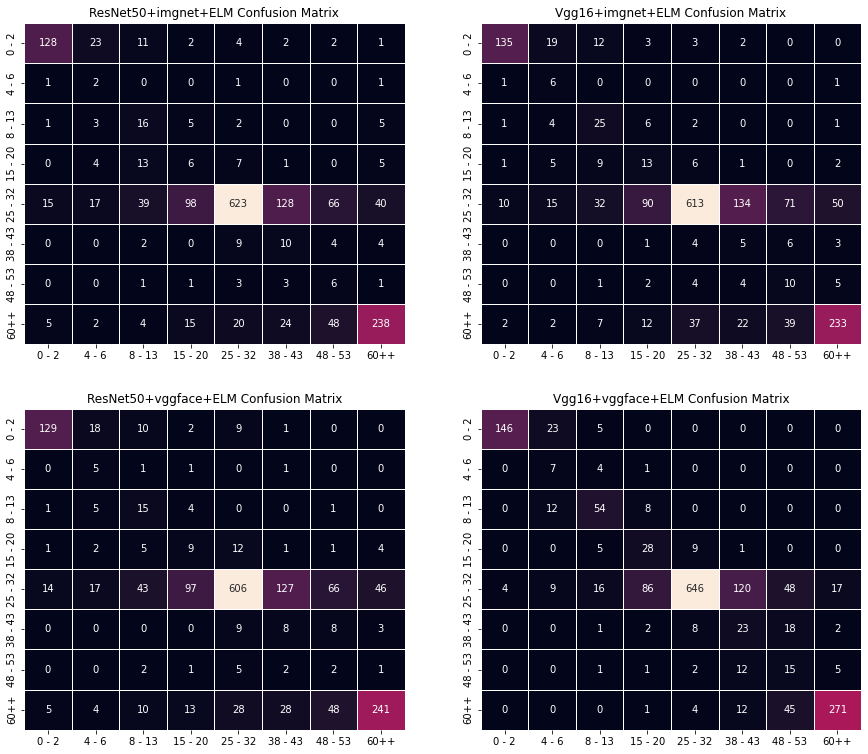

In [17]:
# Confusion Matrix
cols = ['0 - 2', '4 - 6', '8 - 13', '15 - 20', '25 - 32', '38 - 43', '48 - 53', '60++']
plt.figure(figsize = (15,13))

plt.subplot(2, 2, 1)
plt.title("ResNet50+imgnet+ELM Confusion Matrix")
conf_mat = cnn_elm_eval['ResNet50+imgnet+ELM']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 2)
plt.title("Vgg16+imgnet+ELM Confusion Matrix")
conf_mat = cnn_elm_eval['Vgg16+imgnet+ELM']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 3)
plt.title("ResNet50+vggface+ELM Confusion Matrix")
conf_mat = cnn_elm_eval['ResNet50+vggface+ELM']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 4)
plt.title("Vgg16+vggface+ELM Confusion Matrix")
conf_mat = cnn_elm_eval['Vgg16+vggface+ELM']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.show()

In [18]:
# Save CNN ELM model
os.makedirs('/kaggle/working/CNN ELM Model/ResNet50+imgnet+ELM')
resnet50_imgnet_elm.save_model("./CNN ELM Model/ResNet50+imgnet+ELM")

os.makedirs('/kaggle/working/CNN ELM Model/Vgg16+imgnet+ELM')
vgg16_imgnet_elm.save_model("./CNN ELM Model/Vgg16+imgnet+ELM")

os.makedirs('/kaggle/working/CNN ELM Model/ResNet50+vggface+ELM')
resnet50_vggface_elm.save_model("./CNN ELM Model/ResNet50+vggface+ELM")

os.makedirs('/kaggle/working/CNN ELM Model/Vgg16+vggface+ELM')
vgg16_vggface_elm.save_model("./CNN ELM Model/Vgg16+vggface+ELM")

In [19]:
# Save CNN ELM data report
os.makedirs('/kaggle/working/CNN ELM Report')
df_eval_cnn_elm.to_csv("./CNN ELM Report/cnn_elm_report.csv", index = False)

# 5. Experiments using Backpropagation 

In [20]:
# helper function for training backpropagation model
def train_cnn_bp(model, dataset_train, dataset_eval):
    
    # Start Timer
    start = time.time()
        
    # Train model
    history = model.fit(
        dataset_train,
        epochs = 25,
        validation_data = dataset_eval
    )
    
    # Stop Timer
    stop = time.time()
    total_time = stop - start
    
    return model, history, total_time


# helper function for evaluate backpropagation model
def evaluate_cnn_bp(model, dataset_eval, total_size, verbose = 1):
    
    # Start Timer and progbar
    pb = Progbar(len(dataset_eval), stateful_metrics = ['acc'], verbose = verbose)
    start = time.time()
    
    # Predict images per batch
    batches = 0
    preds = np.array([]).reshape(0, model.layers[-1].output.shape[1])
    labels = np.array([]).reshape(0, model.layers[-1].output.shape[1])
    for i, (x_batch, y_batch) in enumerate(dataset_eval):
        # predict Images
        preds = np.vstack([preds, model.predict(x_batch)])
        labels = np.vstack([labels,y_batch])

        # Update progbar
        pb.update(i)
        
        # Batch Iterator
        batches += 1
        if batches >= total_size / 32:
            break
    
    # Stop Timer
    stop = time.time()
    total_time = stop - start

    # Calculate acc, precision, recall, f1-score
    acc = accuracy_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1))
    prec = precision_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
    rec = recall_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
    f1 = f1_score(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1), average = 'macro')
    
    # conf matrix
    cm = confusion_matrix(np.argmax(preds, axis=-1), np.argmax(labels, axis=-1))

    # Update progbar
    pb.update(len(dataset_eval), values = [('acc', acc)], finalize = True)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'cm': cm}, total_time   

In [21]:
# Model Performance Criteria (On Test Data)
cnn_bp_eval = {
    'ResNet50+imgnet+BP' : {},
    'Vgg16+imgnet+BP' : {},
    'ResNet50+vggface+BP' : {},
    'Vgg16+vggface+BP' : {}   
}

## 5.1. ResNet50 (Imagenet Weights) Backpropagation

In [23]:
# Create ResNet50 (imagenet) as Conv Layer
base_model = ResNet50(include_top = False, weights = 'imagenet',input_shape = (224,224,3))
base_model.trainable = False
resnet50_imgnet_bp = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, 'sigmoid'),
    Dense(8, 'softmax')
])

# compile model
resnet50_imgnet_bp.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Fit Model
print("Training ResNet50 (imgnet weights) BP")
resnet50_imgnet_bp, history_resnet50_imgnet_bp, train_time = train_cnn_bp(resnet50_imgnet_bp, train_data, val_data)

# Evaluate on Test
print("\nEvaluating on Test Data")
test_report, test_time = evaluate_cnn_bp(resnet50_imgnet_bp, test_data, len(x_test))

# Add to Time Performance Report
cnn_bp_eval['ResNet50+imgnet+BP']['Train Time'] = train_time
cnn_bp_eval['ResNet50+imgnet+BP']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_bp_eval['ResNet50+imgnet+BP']['Accuracy'] = test_report['acc']
cnn_bp_eval['ResNet50+imgnet+BP']['Precision'] = test_report['prec']
cnn_bp_eval['ResNet50+imgnet+BP']['Recall'] = test_report['rec']
cnn_bp_eval['ResNet50+imgnet+BP']['F1-Score'] = test_report['f1']
cnn_bp_eval['ResNet50+imgnet+BP']['Confusion Matrix'] = test_report['cm']

Training ResNet50 (imgnet weights) BP
Epoch 1/25
418/418 [==============================] - 42s 93ms/step - loss: 1.7824 - accuracy: 0.4064 - val_loss: 1.7942 - val_accuracy: 0.3995
Epoch 2/25
418/418 [==============================] - 39s 92ms/step - loss: 1.7720 - accuracy: 0.4064 - val_loss: 1.7703 - val_accuracy: 0.3995
Epoch 3/25
418/418 [==============================] - 38s 92ms/step - loss: 1.7588 - accuracy: 0.4064 - val_loss: 1.7573 - val_accuracy: 0.3995
Epoch 4/25
418/418 [==============================] - 38s 91ms/step - loss: 1.7486 - accuracy: 0.4064 - val_loss: 1.7537 - val_accuracy: 0.3995
Epoch 5/25
418/418 [==============================] - 40s 96ms/step - loss: 1.7406 - accuracy: 0.4080 - val_loss: 1.7446 - val_accuracy: 0.4055
Epoch 6/25
418/418 [==============================] - 39s 92ms/step - loss: 1.7331 - accuracy: 0.4068 - val_loss: 1.7296 - val_accuracy: 0.3995
Epoch 7/25
418/418 [==============================] - 38s 90ms/step - loss: 1.7234 - accuracy: 0.4

## 5.2. VGG16 (Imagenet Weights) Backpropagation

In [24]:
# Create VGG16(imgnet weights) as Conv Layer
base_model = VGG16(include_top = False, weights = 'imagenet',input_shape = (224,224,3))
base_model.trainable = False
vgg16_imgnet_bp = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, 'sigmoid'),
    Dense(8, 'softmax')
])

# compile model
vgg16_imgnet_bp.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Fit Model
print("Training Vgg16 (imgnet weights) BP")
vgg16_imgnet_bp, history_vgg16_imgnet_bp, train_time = train_cnn_bp(vgg16_imgnet_bp, train_data, val_data)

# Evaluate on Test
print("\nEvaluating on Test Data")
test_report, test_time = evaluate_cnn_bp(vgg16_imgnet_bp, test_data, len(x_test))

# Add to Time performance Report
cnn_bp_eval['Vgg16+imgnet+BP']['Train Time'] = train_time
cnn_bp_eval['Vgg16+imgnet+BP']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_bp_eval['Vgg16+imgnet+BP']['Accuracy'] = test_report['acc']
cnn_bp_eval['Vgg16+imgnet+BP']['Precision'] = test_report['prec']
cnn_bp_eval['Vgg16+imgnet+BP']['Recall'] = test_report['rec']
cnn_bp_eval['Vgg16+imgnet+BP']['F1-Score'] = test_report['f1']
cnn_bp_eval['Vgg16+imgnet+BP']['Confusion Matrix'] = test_report['cm']

Training Vgg16 (imgnet weights) BP
Epoch 1/25
418/418 [==============================] - 45s 100ms/step - loss: 1.6727 - accuracy: 0.4295 - val_loss: 1.5755 - val_accuracy: 0.4468
Epoch 2/25
418/418 [==============================] - 38s 91ms/step - loss: 1.5172 - accuracy: 0.4994 - val_loss: 1.4437 - val_accuracy: 0.5353
Epoch 3/25
418/418 [==============================] - 38s 91ms/step - loss: 1.4277 - accuracy: 0.5332 - val_loss: 1.3702 - val_accuracy: 0.5628
Epoch 4/25
418/418 [==============================] - 38s 91ms/step - loss: 1.3670 - accuracy: 0.5528 - val_loss: 1.3189 - val_accuracy: 0.5801
Epoch 5/25
418/418 [==============================] - 38s 90ms/step - loss: 1.3251 - accuracy: 0.5617 - val_loss: 1.2762 - val_accuracy: 0.5849
Epoch 6/25
418/418 [==============================] - 36s 86ms/step - loss: 1.2926 - accuracy: 0.5696 - val_loss: 1.2576 - val_accuracy: 0.5861
Epoch 7/25
418/418 [==============================] - 37s 88ms/step - loss: 1.2678 - accuracy: 0.574

## 5.3. ResNet50 (VGGFace Weights) Backpropagation 

In [25]:
# Create ResNet50 (Vggface weights) Model
base_model = VGGFace(model = 'resnet50', include_top = False, input_shape = (224,224,3),weights ='vggface')
base_model.trainable = False
resnet50_vggface_bp = tf.keras.Sequential([
    base_model, 
    GlobalAveragePooling2D(), 
    Dense(1024, activation = "sigmoid"),
    Dense(8, activation = "softmax")
])

# compile model
resnet50_vggface_bp.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Fit Model
print("Training ResNet50 (VGGFace weights) BP")
resnet50_vggface_bp, history_resnet50_vggface_bp, train_time = train_cnn_bp(resnet50_vggface_bp, train_data, val_data)

# Evaluate on Test
print("\nEvaluating on Test Data")
test_report, test_time = evaluate_cnn_bp(resnet50_vggface_bp, test_data, len(x_test))

# Add to Time Performance Report
cnn_bp_eval['ResNet50+vggface+BP']['Train Time'] = train_time
cnn_bp_eval['ResNet50+vggface+BP']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_bp_eval['ResNet50+vggface+BP']['Accuracy'] = test_report['acc']
cnn_bp_eval['ResNet50+vggface+BP']['Precision'] = test_report['prec']
cnn_bp_eval['ResNet50+vggface+BP']['Recall'] = test_report['rec']
cnn_bp_eval['ResNet50+vggface+BP']['F1-Score'] = test_report['f1']
cnn_bp_eval['ResNet50+vggface+BP']['Confusion Matrix'] = test_report['cm']

Training ResNet50 (VGGFace weights) BP
Epoch 1/25
418/418 [==============================] - 41s 93ms/step - loss: 1.7902 - accuracy: 0.4064 - val_loss: 1.8093 - val_accuracy: 0.3995
Epoch 2/25
418/418 [==============================] - 39s 93ms/step - loss: 1.7858 - accuracy: 0.4064 - val_loss: 1.7960 - val_accuracy: 0.3995
Epoch 3/25
418/418 [==============================] - 38s 90ms/step - loss: 1.7842 - accuracy: 0.4064 - val_loss: 1.8156 - val_accuracy: 0.3995
Epoch 4/25
418/418 [==============================] - 38s 91ms/step - loss: 1.7835 - accuracy: 0.4064 - val_loss: 1.8016 - val_accuracy: 0.3995
Epoch 5/25
418/418 [==============================] - 37s 89ms/step - loss: 1.7808 - accuracy: 0.4064 - val_loss: 1.8166 - val_accuracy: 0.3995
Epoch 6/25
418/418 [==============================] - 39s 93ms/step - loss: 1.7802 - accuracy: 0.4064 - val_loss: 1.7940 - val_accuracy: 0.3995
Epoch 7/25
418/418 [==============================] - 38s 91ms/step - loss: 1.7812 - accuracy: 0.

## 5.4. VGG16 (VGGFace Weights) Backpropagation 

In [27]:
# Create VGG16 (vggface weights) Model
base_model = VGGFace(model = 'vgg16', include_top = False, input_shape = (224,224,3), weights = 'vggface')
base_model.trainable = False
vgg16_vggface_bp = tf.keras.Sequential([
    base_model, 
    GlobalAveragePooling2D(), 
    Dense(1024, activation = "sigmoid"),
    Dense(8, activation = "softmax")
])

# compile model
vgg16_vggface_bp.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Fit Model
print("Training Vgg16 (VGGFace weights) BP")
vgg16_vggface_bp, history_vgg16_vggface_bp, train_time = train_cnn_bp(vgg16_vggface_bp, train_data, val_data)

# Evaluate on Test
print("\nEvaluating on Test Data")
test_report, test_time = evaluate_cnn_bp(vgg16_vggface_bp, test_data, len(x_test))

# Add to time performance report
cnn_bp_eval['Vgg16+vggface+BP']['Train Time'] = train_time
cnn_bp_eval['Vgg16+vggface+BP']['Test Time'] = test_time

# Add to Classification Performance Report
cnn_bp_eval['Vgg16+vggface+BP']['Accuracy'] = test_report['acc']
cnn_bp_eval['Vgg16+vggface+BP']['Precision'] = test_report['prec']
cnn_bp_eval['Vgg16+vggface+BP']['Recall'] = test_report['rec']
cnn_bp_eval['Vgg16+vggface+BP']['F1-Score'] = test_report['f1']
cnn_bp_eval['Vgg16+vggface+BP']['Confusion Matrix'] = test_report['cm']

Training Vgg16 (VGGFace weights) BP
Epoch 1/25
418/418 [==============================] - 39s 91ms/step - loss: 1.7301 - accuracy: 0.3956 - val_loss: 1.6458 - val_accuracy: 0.3995
Epoch 2/25
418/418 [==============================] - 37s 89ms/step - loss: 1.5746 - accuracy: 0.4412 - val_loss: 1.5037 - val_accuracy: 0.4809
Epoch 3/25
418/418 [==============================] - 36s 86ms/step - loss: 1.4482 - accuracy: 0.5478 - val_loss: 1.3818 - val_accuracy: 0.6011
Epoch 4/25
418/418 [==============================] - 37s 89ms/step - loss: 1.3364 - accuracy: 0.6022 - val_loss: 1.2716 - val_accuracy: 0.6202
Epoch 5/25
418/418 [==============================] - 37s 89ms/step - loss: 1.2441 - accuracy: 0.6194 - val_loss: 1.1850 - val_accuracy: 0.6370
Epoch 6/25
418/418 [==============================] - 37s 88ms/step - loss: 1.1670 - accuracy: 0.6294 - val_loss: 1.1216 - val_accuracy: 0.6411
Epoch 7/25
418/418 [==============================] - 37s 89ms/step - loss: 1.1059 - accuracy: 0.637

## 5.5. Evaluating Result

In [28]:
# summary by dataframe
df_eval_cnn_bp = pd.DataFrame.from_dict(cnn_bp_eval).transpose().reset_index().drop(columns = ['Confusion Matrix'])
df_eval_cnn_bp.rename(columns = {'index':'Model'}, inplace = True)
df_eval_cnn_bp

,Model,Train Time,Test Time,Accuracy,Precision,Recall,F1-Score
0,ResNet50+imgnet+BP,956.506486,10.05353,0.486244,0.201358,0.25869,0.18052
1,Vgg16+imgnet+BP,938.014056,12.278996,0.61244,0.381723,0.530583,0.358784
2,ResNet50+vggface+BP,938.209022,9.339189,0.40012,0.125,0.050015,0.071444
3,Vgg16+vggface+BP,939.896134,11.904325,0.711124,0.507764,0.654606,0.509844


In [29]:
# Validation History
history_resnet50_imgnet_bp = history_resnet50_imgnet_bp.history
history_vgg16_imgnet_bp = history_vgg16_imgnet_bp.history
history_resnet50_vggface_bp = history_resnet50_vggface_bp.history
history_vgg16_vggface_bp = history_vgg16_vggface_bp.history

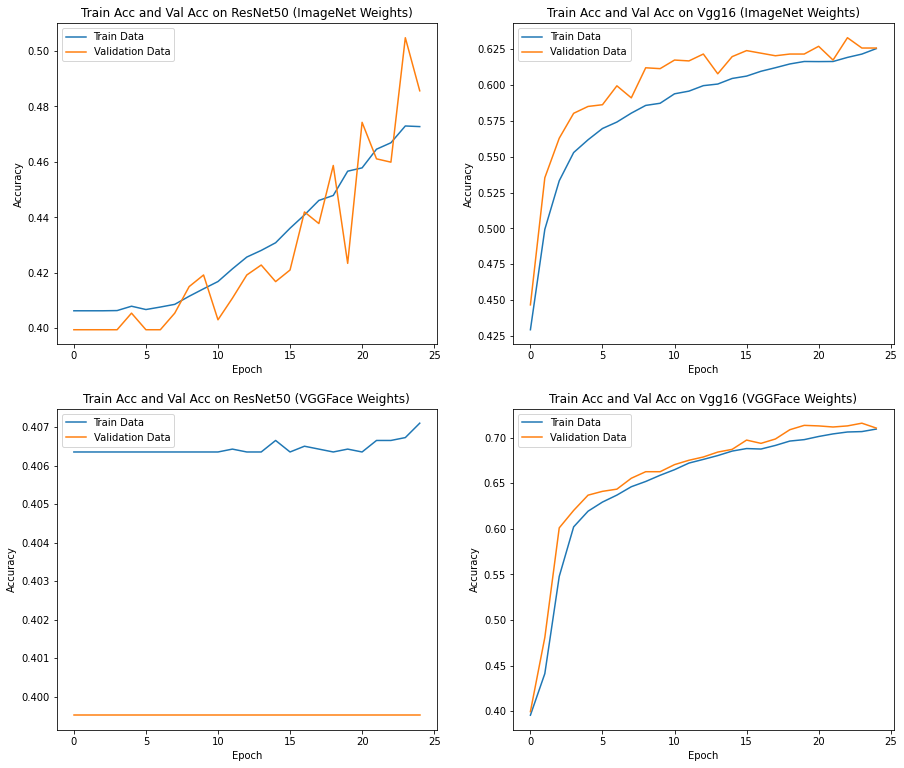

In [1]:
# Plot Train and validation History
plt.figure(figsize = (15,13))
plt.subplot(2,2,1)
plt.plot(history_resnet50_imgnet_bp['accuracy'], label = "Train Data")
plt.plot(history_resnet50_imgnet_bp['val_accuracy'], label = "Validation Data")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train Acc and Val Acc on ResNet50 (ImageNet Weights)")

plt.subplot(2,2,2)
plt.plot(history_vgg16_imgnet_bp['accuracy'], label = "Train Data")
plt.plot(history_vgg16_imgnet_bp['val_accuracy'], label = "Validation Data")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train Acc and Val Acc on Vgg16 (ImageNet Weights)")

plt.subplot(2,2,3)
plt.plot(history_resnet50_vggface_bp['accuracy'], label = "Train Data")
plt.plot(history_resnet50_vggface_bp['val_accuracy'], label = "Validation Data")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train Acc and Val Acc on ResNet50 (VGGFace Weights)")

plt.subplot(2,2,4)
plt.plot(history_vgg16_vggface_bp['accuracy'], label = "Train Data")
plt.plot(history_vgg16_vggface_bp['val_accuracy'], label = "Validation Data")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train Acc and Val Acc on Vgg16 (VGGFace Weights)")

plt.show()

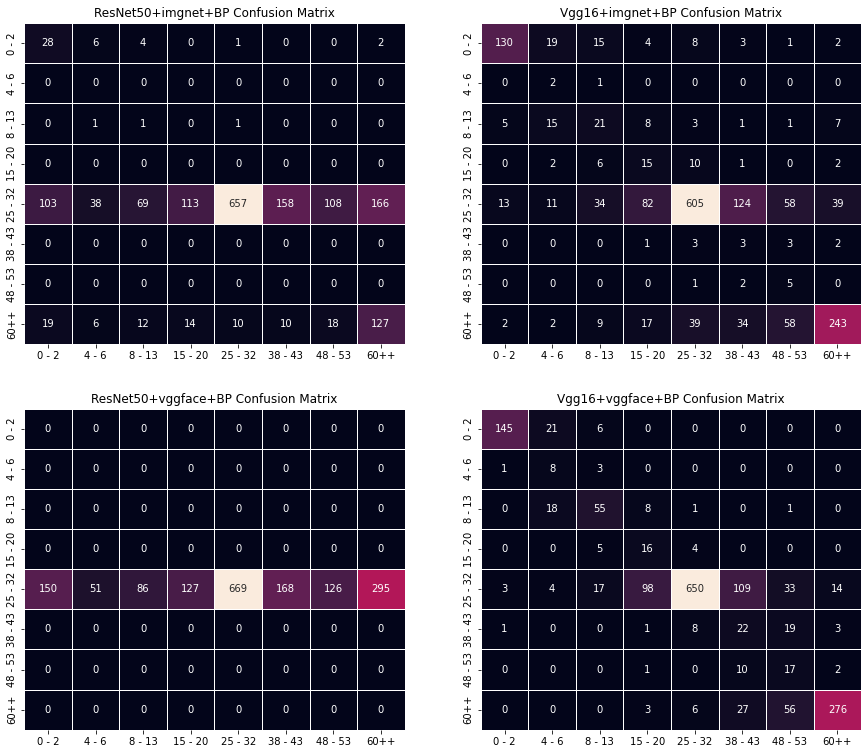

In [31]:
# Confusion matrix 
cols = ['0 - 2', '4 - 6', '8 - 13', '15 - 20', '25 - 32', '38 - 43', '48 - 53', '60++']
plt.figure(figsize = (15,13))

plt.subplot(2, 2, 1)
plt.title("ResNet50+imgnet+BP Confusion Matrix")
conf_mat = cnn_bp_eval['ResNet50+imgnet+BP']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 2)
plt.title("Vgg16+imgnet+BP Confusion Matrix")
conf_mat = cnn_bp_eval['Vgg16+imgnet+BP']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 3)
plt.title("ResNet50+vggface+BP Confusion Matrix")
conf_mat = cnn_bp_eval['ResNet50+vggface+BP']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.subplot(2, 2, 4)
plt.title("Vgg16+vggface+BP Confusion Matrix")
conf_mat = cnn_bp_eval['Vgg16+vggface+BP']['Confusion Matrix']
sns.heatmap(pd.DataFrame(conf_mat, columns=cols,index=cols), annot = True, fmt = 'g', cbar = False, linewidths =.5)

plt.show()

In [32]:
# Save backpropagation Model
os.makedirs('/kaggle/working/CNN BP Model')
resnet50_imgnet_bp.save('./CNN BP Model/resnet50_imgnet_bp.h5')
vgg16_imgnet_bp.save('./CNN BP Model/vgg16_imgnet_bp.h5')
resnet50_vggface_bp.save('./CNN BP Model/resnet50_vggface_bp.h5')
vgg16_vggface_bp.save('./CNN BP Model/vgg16_vggface_bp.h5')

In [33]:
# Save CNN BP data report
os.makedirs('/kaggle/working/CNN BP Report')
df_eval_cnn_bp.to_csv("./CNN BP Report/cnn_bp_report.csv", index = False)
pd.DataFrame(history_resnet50_imgnet_bp).to_csv("./CNN BP Report/resnet50_imgnet_bp_hist.csv", index = False)
pd.DataFrame(history_vgg16_imgnet_bp).to_csv("./CNN BP Report/vgg16_imgnet_bp_hist.csv", index = False)
pd.DataFrame(history_resnet50_vggface_bp).to_csv("./CNN BP Report/resnet50_vggface_bp_hist.csv", index = False)
pd.DataFrame(history_vgg16_vggface_bp).to_csv("./CNN BP Report/vgg16_vggface_bp_hist.csv", index = False)

# 6. Overall Summary

In [34]:
# Marge all Schema
df_summary = pd.concat([df_eval_cnn_elm,df_eval_cnn_bp]).reset_index().drop(columns = ['index'])
df_summary

,Model,Train Time,Test Time,Accuracy,Precision,Recall,F1-Score
0,ResNet50+imgnet+ELM,71.559383,9.336356,0.615431,0.371375,0.478391,0.357715
1,Vgg16+imgnet+ELM,69.555467,9.914344,0.62201,0.403245,0.553518,0.403296
2,ResNet50+vggface+ELM,67.428524,9.134483,0.607057,0.373699,0.487207,0.363025
3,Vgg16+vggface+ELM,68.439223,9.851466,0.711722,0.512398,0.642823,0.522915
4,ResNet50+imgnet+BP,956.506486,10.05353,0.486244,0.201358,0.25869,0.18052
5,Vgg16+imgnet+BP,938.014056,12.278996,0.61244,0.381723,0.530583,0.358784
6,ResNet50+vggface+BP,938.209022,9.339189,0.40012,0.125,0.050015,0.071444
7,Vgg16+vggface+BP,939.896134,11.904325,0.711124,0.507764,0.654606,0.509844
